In [39]:
! pip install -q pandas matplotlib scikit-learn openai dotenv tqdm liqfit sentencepiece transformers

import sys
print("Current python version: ", sys.version)

import pandas as pd
import matplotlib.pyplot as plt
import re


Current python version:  3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]


# Prepare supreme courts data for labeling 

In [53]:
# read parquet file
df = pd.read_parquet('2024-supreme-court-decisions.parquet')
df.head()

,id,text
0,116067089,УХВАЛА\n\n29 грудня 2023 року\nм. Київ\nсправа...
1,116075955,УХВАЛА\nІМЕНЕМ УКРАЇНИ\n\n01 грудня 2023 року\...
2,116075956,У Х В А Л А\n\n01 грудня 2023 року\nм. Київ\n\...
3,116075957,УХВАЛА\n30 листопада 2023 року\nм. Київ\nсправ...
4,116075958,У Х В А Л А\n\n01 грудня 2023 року\nм. Київ\n\...


In [54]:
# trim to .01 and .99 quantiles
df = df[df['text'].str.len().quantile(0.01) <= df['text'].str.len()]
df = df[df['text'].str.len().quantile(0.99) >= df['text'].str.len()]
# Print size distribution of text column chart

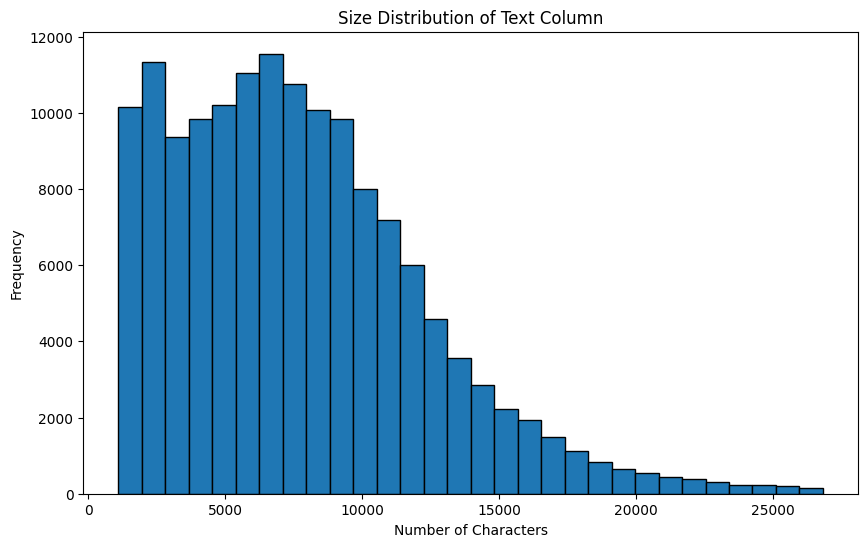

In [55]:
# Print size distribution of text column chart
plt.figure(figsize=(10, 6))
plt.hist(df['text'].str.len(), bins=30, edgecolor='black')
plt.title('Size Distribution of Text Column')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


In [56]:
# Limit to 1000/10000 charachters
df = df[df['text'].str.len() > 2_000]
df = df[df['text'].str.len() < 10_000]
df['text'].str.len().describe()

count    96745.000000
mean      5963.243930
std       2271.563927
min       2001.000000
25%       4035.000000
50%       6023.000000
75%       7870.000000
max       9999.000000
Name: text, dtype: float64

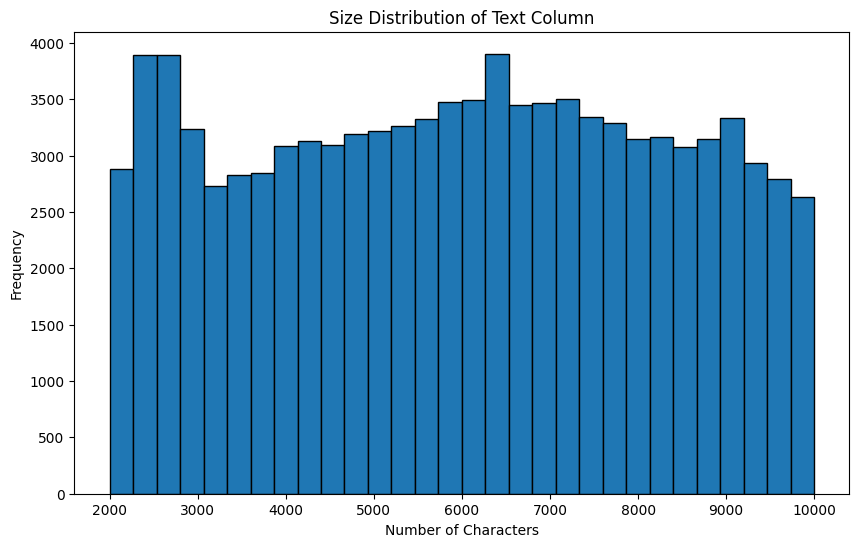

In [57]:
plt.figure(figsize=(10, 6))
plt.hist(df['text'].str.len(), bins=30, edgecolor='black')
plt.title('Size Distribution of Text Column')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [78]:
entites = {
    'НОМЕР_': 'number',
    'ІНФОРМАЦІЯ_': 'information',
    'ОСОБА_': 'person',
    'АДРЕСА_': 'address',
}

df['number_count'] = df['text'].str.count('НОМЕР_')
df['information_count'] = df['text'].str.count('ІНФОРМАЦІЯ_')
df['person_count'] = df['text'].str.count('ОСОБА_')
df['address_count'] = df['text'].str.count('АДРЕСА_')

# Limit to at least 1 occurrence of at least 2 of the counts
df['sum_of_unique_entities'] = df.apply(lambda row: sum([row['number_count'] > 0,  row['information_count'] > 0, row['person_count'] > 0, row['address_count'] > 0]), axis=1)


# Iterate documents and collect a list of occurrences of 'НОМЕР_' entity.
# Each occurance should have a text followed by 'НОМЕР_' entity.
# Include only 5 words before 'НОМЕР_' entity.
# Collect all the occurrences and save them to a file new column.


number_occurrences = []

df['number_occurrences'] = None
df['information_occurrences'] = None
df['person_occurrences'] = None
df['address_occurrences'] = None

for index, row in df.iterrows():
    text = row['text']
    
    
    for entity_name, entity_column in entites.items():
        unique_entities = set(re.findall(entity_name + '\d+', text))
        
        entity_occurrences = {}

        for entity in unique_entities:
            # For each occurrence of entity, add start and end positions to the entity_occurrences dictionary
            entity_occurrences[entity] = []
            entity_positions = [(m.start(), m.end()) for m in re.finditer(entity, text)]
            for start, end in entity_positions:
                entity_occurrences[entity].append((start, end))
    
        df.at[index, entity_column + '_occurrences'] = entity_occurrences


df_filtered = df[df['sum_of_unique_entities'] >= 2]
df_filtered.describe()

,number_count,information_count,person_count,address_count,sum_of_unique_entities
count,17952.000000,17952.000000,17952.000000,17952.000000,17952.000000
mean,2.813781,1.582164,11.058824,0.814338,2.195243
std,4.183873,3.010379,10.111340,2.123508,0.439579
min,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,0.000000,4.000000,0.000000,2.000000
50%,0.000000,0.000000,8.000000,0.000000,2.000000
75%,5.000000,2.000000,15.000000,1.000000,2.000000
max,52.000000,37.000000,300.000000,137.000000,4.000000


In [75]:
# Select 40 documents for labeling (with seed)
limit_of_entities = 5
df_supreme_court_for_labeling = df_filtered[(df_filtered['number_count'] < limit_of_entities) & (df_filtered['information_count'] < limit_of_entities) & (df_filtered['person_count'] < limit_of_entities) & (df_filtered['address_count'] < limit_of_entities)].sample(n=40, random_state=42)
df_supreme_court_for_labeling.to_csv('./supreme_court_for_labeling.csv', index=False)
df_supreme_court_for_labeling.head()


,id,text,number_count,information_count,person_count,address_count,sum_of_unique_entities
63765,119454032,УХВАЛА\n31 травня 2024 року\nм. Київ\nсправа №...,2,0,2,0,2
6432,116416289,УХВАЛА\n\n16 січня 2024 року\nм. Київ\n\nсправ...,0,2,2,0,2
31557,117729892,УХВАЛА\n18 березня 2024 року\nм. Київ\nсправа ...,0,0,4,1,2
130636,123085089,УХВАЛА\n\n18 листопада 2024 року\nм. Київ\nспр...,3,1,2,0,3
56432,119026436,УХВАЛА\n\n13 травня 2024 року\n\nм. Київ\n\nсп...,2,0,4,0,2


# Load already labeled data (not only supreme court)

In [66]:
# merge already labeled data
df_all_courts_labeled = pd.read_csv('../../experiments/df_labeled_40.csv')
df_all_courts_labeled['sum_of_unique_entities'] = df.apply(lambda row: sum([row['number_count'] > 0,  row['information_count'] > 0, row['person_count'] > 0, row['address_count'] > 0]), axis=1)
df_all_courts_labeled.head()


,address_count,address_occurrences,annotation_id,annotator,case,created_at,gender,id,information,information_count,information_occurrences,lead_time,number,number_count,number_occurrences,person_count,person_occurrences,text,updated_at,sum_of_unique_entities
0,2,"{'АДРЕСА_1': [(543, 551), (975, 983)]}",12,1,NaN,2025-03-27T18:44:18.047625Z,NaN,121315471,"[{""end"":540,""text"":""ІНФОРМАЦІЯ_1"",""start"":528,...",2,"{'ІНФОРМАЦІЯ_1': [(528, 540), (960, 972)]}",50.061,"[{""end"":565,""text"":""НОМЕР_1"",""start"":558,""labe...",2,"{'НОМЕР_1': [(558, 565), (990, 997)]}",0,{},ПІВНІЧНИЙ АПЕЛЯЦІЙНИЙ ГОСПОДАРСЬКИЙ СУД\nвул. ...,2025-03-27T18:44:18.047651Z,1.0
1,2,"{'АДРЕСА_1': [(641, 649), (1142, 1150)]}",9,1,"[{""end"":574,""text"":""ОСОБА_1"",""start"":567,""labe...",2025-03-27T18:41:58.885291Z,"[{""end"":574,""text"":""ОСОБА_1"",""start"":567,""labe...",120928720,"[{""end"":589,""text"":""ІНФОРМАЦІЯ_1"",""start"":577,...",2,"{'ІНФОРМАЦІЯ_1': [(577, 589), (1078, 1090)]}",58.071,"[{""end"":606,""text"":""НОМЕР_1"",""start"":599,""labe...",2,"{'НОМЕР_1': [(599, 606), (1100, 1107)]}",3,"{'ОСОБА_1': [(488, 495), (567, 574), (1068, 10...",Справа №186/1237/24\nПровадження № 2-н/0186/21...,2025-03-27T18:41:58.885311Z,1.0
2,2,"{'АДРЕСА_1': [(536, 544), (1089, 1097)]}",28,1,NaN,2025-03-27T19:05:59.017056Z,NaN,122151597,"[{""end"":421,""text"":""ІНФОРМАЦІЯ_1"",""start"":409,...",2,"{'ІНФОРМАЦІЯ_1': [(409, 421), (962, 974)]}",47.201,"[{""end"":435,""text"":""НОМЕР_1"",""start"":428,""labe...",4,"{'НОМЕР_2': [(452, 459), (1005, 1012)], 'НОМЕР...",0,{},ПІВНІЧНИЙ АПЕЛЯЦІЙНИЙ ГОСПОДАРСЬКИЙ СУД\nвул. ...,2025-03-27T19:05:59.017077Z,1.0
3,2,"{'АДРЕСА_1': [(496, 504), (718, 726)]}",8,1,"[{""end"":493,""text"":""ОСОБА_1"",""start"":486,""labe...",2025-03-27T18:41:52.446130Z,"[{""end"":493,""text"":""ОСОБА_1"",""start"":486,""labe...",121218990,"[{""end"":540,""text"":""ІНФОРМАЦІЯ_1"",""start"":528,...",2,"{'ІНФОРМАЦІЯ_1': [(528, 540), (750, 762)]}",158.202,"[{""end"":525,""text"":""НОМЕР_1"",""start"":518,""labe...",2,"{'НОМЕР_1': [(518, 525), (740, 747)]}",2,"{'ОСОБА_1': [(486, 493), (708, 715)]}",ГОСПОДАРСЬКИЙ СУД ВОЛИНСЬКОЇ ОБЛАСТІ\nНАКАЗ\nп...,2025-03-27T18:41:52.446152Z,2.0
4,2,"{'АДРЕСА_1': [(541, 549)], 'АДРЕСА_2': [(8292,...",15,1,"[{""end"":8638,""text"":""ОСОБА_1"",""start"":8631,""la...",2025-03-27T18:48:50.819676Z,"[{""end"":8638,""text"":""ОСОБА_1"",""start"":8631,""la...",122318861,"[{""end"":536,""text"":""ІНФОРМАЦІЯ_2"",""start"":524,...",2,"{'ІНФОРМАЦІЯ_2': [(524, 536)], 'ІНФОРМАЦІЯ_1':...",840.548,"[{""end"":570,""text"":""НОМЕР_4"",""start"":563,""labe...",5,"{'НОМЕР_5': [(8314, 8321)], 'НОМЕР_2': [(134, ...",2,"{'ОСОБА_2': [(8703, 8710)], 'ОСОБА_1': [(8631,...",ГОСПОДАРСЬКИЙ СУД РІВНЕНСЬКОЇ ОБЛАСТІ\nвул. Да...,2025-03-28T10:56:05.334514Z,1.0


# Load supreme court lebeled data

In [ ]:
df_supreme_court_labeled = pd.read_csv('../../experiments/df_labeled_supreme_court_40.csv')
df_supreme_court_labeled.head()

